In [1]:
import glob
import os

import numpy as np
import pandas as pd
import scipy
from scipy import stats

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec


In [2]:
FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = 'figures'


def save_plot(save_path, bbox_inches='tight', should_print=False):
    if save_path is not None:
        save_path_no_ext = os.path.splitext(save_path)[0]
        if should_print:
            print('Figure:\n')
            print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('\nWrapfigure:\n')
            print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX):
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')

In [3]:
IGNORE_LIST = ('saycam_split_text_test.csv', 'saycam_nan_test.csv')

def load_and_join_dataframes(folder, ext='.csv', ignore_list=IGNORE_LIST) -> pd.DataFrame:
    files = glob.glob(os.path.join(folder, '*' + ext))
    df = pd.concat([pd.read_csv(f) for f in files if os.path.basename(f) not in ignore_list])
    df.reset_index(drop=True, inplace=True)
    return df
    
combined_df = load_and_join_dataframes('../embedding_outputs')
combined_df.drop(columns=[combined_df.columns[0]], inplace=True)
combined_df.rotate_angle.fillna(0, inplace=True)
combined_df.rotate_angle = combined_df.rotate_angle.astype(int)

In [4]:
combined_df.head()

,model_name,condition,acc_mean,acc_std,acc_sem,relation,two_reference_objects,adjacent_reference_objects,n_target_types,transpose_stimuli,n_habituation_stimuli,rotate_angle,seed,n_examples,extra_diagonal_margin
0,mobilenet-random,different_shapes,0.508789,0.499923,0.015623,above_below,0,0,1,0,1,0,34,1024,5
1,mobilenet-random,split_text,0.117188,0.321644,0.010051,above_below,0,0,1,0,1,0,34,1024,5
2,mobilenet-random,random_color,0.493164,0.499953,0.015624,above_below,0,0,1,0,1,0,34,1024,5
3,resnext-random,different_shapes,0.469727,0.499083,0.015596,above_below,0,0,1,0,1,0,34,1024,5
4,resnext-random,split_text,0.115234,0.319305,0.009978,above_below,0,0,1,0,1,0,34,1024,5


In [18]:
combined_df.groupby(['model_name', 'condition']).acc_mean.max()

model_name             condition       
mobilenet-imagenet     different_shapes    0.784180
                       random_color        0.686523
                       split_text          0.157227
mobilenet-random       different_shapes    0.535156
                       random_color        0.541016
                       split_text          0.124023
mobilenet-saycam(S)    different_shapes    0.890625
                       random_color        0.879883
                       split_text          0.187500
resnext-DINO-ImageNet  different_shapes    0.757812
                       random_color        0.738281
                       split_text          0.160156
resnext-DINO-S         different_shapes    0.877930
                       random_color        0.884766
                       split_text          0.175781
resnext-imagenet       different_shapes    0.862305
                       random_color        0.857422
                       split_text          0.186523
resnext-random         d

[(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]

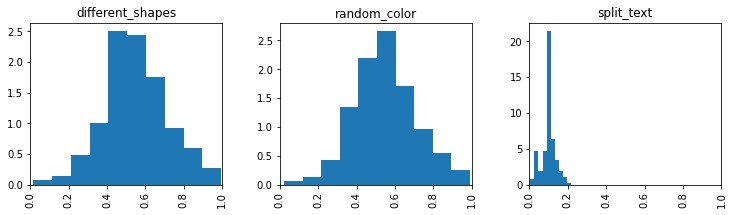

In [38]:
axes = combined_df.acc_mean.hist(by=combined_df.condition, density=True, figsize=(12, 3), layout=(1, 3))
[ax.set_xlim(0, 1) for ax in axes]

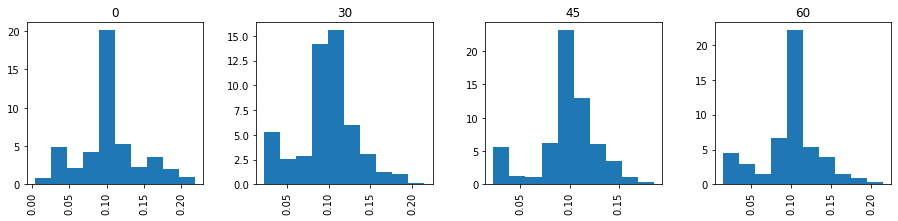

In [40]:
split_text_df = combined_df[combined_df.condition.eq('split_text')]
axes = split_text_df.acc_mean.hist(by=split_text_df.rotate_angle, density=True, figsize=(15, 3), layout=(1, 4))

Text(0.5, 0.98, 'Untrained models accuracy distribution by condition')

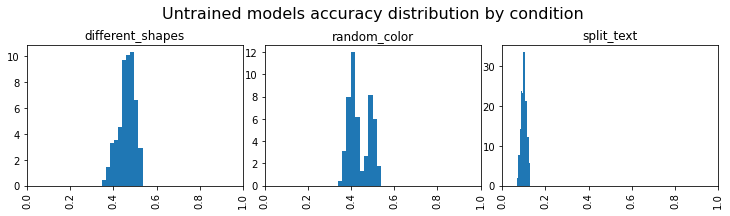

In [24]:
random_models_df = combined_df[combined_df.model_name.str.endswith('-random')]

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
fig.subplots_adjust(wspace=0.1, top=0.8)

axes = random_models_df.acc_mean.hist(ax=ax, by=random_models_df.condition, density=True)
[ax.set_xlim(0, 1) for ax in axes]

fig.subplots_adjust(wspace=0.1, top=0.8)

plt.suptitle('Untrained models accuracy distribution by condition', fontsize=16)

Text(0.5, 0.98, 'Mobilenet-(S) accuracy distribution by condition')

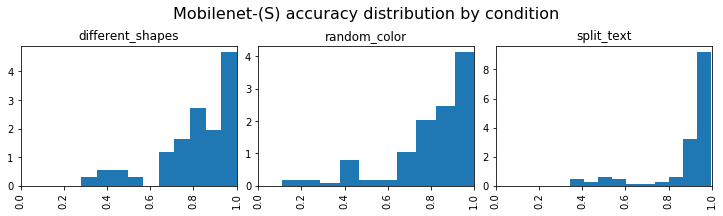

In [4]:
nan_test_df = pd.read_csv('../embedding_outputs/saycam_nan_test.csv')

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
fig.subplots_adjust(wspace=0.1, top=0.8)

axes = nan_test_df.acc_mean.hist(ax=ax, by=nan_test_df.condition, density=True)
[ax.set_xlim(0, 1) for ax in axes]

fig.subplots_adjust(wspace=0.1, top=0.8)

plt.suptitle('Mobilenet-(S) accuracy distribution by condition', fontsize=16)

In [25]:
len(random_models_df)

768